# Project 3: Sharing Dataset on Kaggle

![](books.jpg)

Jamalon is the largest online bookstore in the Middle East, offering more than 9.5 million titles of Arabic and English books with home delivery. This dataset contains a wide collection of Arabic books in different fields of different categories.<br><a href = 'https://www.kaggle.com/dareenalharthi/jamalon-arabic-books-dataset'>Click</a> to see  Jamalon arabic books dataset on Kaggle.

In [3]:

import re
import requests
import pandas as pd
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display
from bs4 import BeautifulSoup
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
%matplotlib inline

## Request Jamalon bookstore arabic books HTML page


In [4]:
# Download Jamalon bookstore arabic books HTML page
response = requests.get("https://jamalon.com/ar/books")

In [5]:
# Check the response code to make sure that the request was successfully received
response.status_code

200

In [6]:
# Save the returned HTML page 
html = response.text

In [7]:
# Create object from BeautifulSoup for Jamalon bookstore arabic books HTML page
soup = BeautifulSoup(html, "lxml")

In [8]:
# Extract the categories menu and links from Jamalon HTML page and save it as a list of categories
book_categories_html = soup.find_all("div", attrs={"class":"panel panel-default"})

In [9]:
'''This dictionary will hold the category name as a key and the value will be another dictionary that has subcategories 
names as keys, and the book subcategory URL as values that contains all books from this subcategory'''
book_categories = {}
# Arabic books categories started from 13, from 0 to 12 are English books categories 
for category in book_categories_html[13:]:
    # Create object from BeautifulSoup for category element in "book_categories_html" list
    soup_categ = BeautifulSoup(str(category), "lxml")
    # Extract the category name and save it
    categ_name = re.search(">(.*)[^</span>]",str(soup_categ.find("h4").find("span"))).group(1).strip(" ")
    # Find all subcategories of the current category and save it in the "subcategories" list
    subcategories = soup_categ.find_all("ul", attrs={"class":"list-unstyled"})
    book_categories[str(categ_name)]={}
    ''' For each subcategory find the URL that contains all books from this subcategory and store the 
    subcategory name as key and the URL as a value'''
    for sub in subcategories:
        ls = re.search("a href=(.*) ",str(sub.find("a"))).group(1).split(">")
        # Subcategory URL
        ls[0] = ls[0].strip('"')
        # Subcategory name
        ls[1] = ls[1].split("<")[0].strip(" ").replace("\xa0","")
        book_categories[categ_name][str(ls[1].strip(" "))]=ls[0]
        

## Scrape the Arabic books data from Jamalon bookstore website

In [ ]:
'''This dictionary will hold the category name as a key and the value will be another dictionary that has subcategories 
    names as keys, and for each subcategory the value will be a dictionary of all books information,
    the dictionary will look like this:
    books_data = {"Category name":{
                 "subcategory name":{
                 1:{
                            "Title":title,
                            "Author":author,
                            "Description":description,
                            "Pages":pages, 
                            "Publication year":year,
                            "Publisher":Publisher,
                            "Cover":cover,
                            "Price":price}
                 },
                 2:{
                            "Title":title,
                            "Author":author,
                            "Description":description,
                            "Pages":pages, 
                            "Publication year":year,
                            "Publisher":Publisher,
                            "Cover":cover,
                            "Price":price}
                 }, etc ... 
                }} '''
books_data = {}
for category in book_categories:
    books_data[category] = {}
    for sub_cat in book_categories[category]:
        book_id = 1
        books_data[category][sub_cat]={}
        # Request the subcategory page to get books information
        url = book_categories[category][sub_cat]    
        driver = webdriver.Chrome(executable_path='chromedriver/chromedriver.exe')
        driver.get(url)
        # Take the next page button index to go through books pages 
        try:
            ul = driver.find_element_by_class_name('pagination')
            index = len(ul.find_elements_by_tag_name('li'))
            next_btn_index = index
        except:
            pass
        # The maximum number of pages will be 15
        page_num = 1
        pages_limit= 15
        '''Driver will go through each subcategory books page and click each book card in the page to go to book information page then 
        store the book information in "books_data" dictionary, then return to the subcategory books page, this operation will
        be repeated until reach page 15 or last page (if the number of pages less than 15)'''
        while page_num<= pages_limit :
            try:
                rows = driver.find_element_by_class_name("list").find_elements_by_class_name('row')
            except:
                driver.back()
            # Rows contain all the rows in subcategory books page, each row contain three books cards
            rows_size = len(rows)
            for i in range(rows_size):
                row = driver.find_element_by_class_name("list").find_elements_by_class_name('row')[i]
                books = row.find_elements_by_class_name("col-sm-4")
                books_size = len(books)
                # Click each book card and store the book information in "books_data" dictionary
                for j in range(books_size):
                    row = driver.find_element_by_class_name("list").find_elements_by_class_name('row')[i]
                    book = row.find_elements_by_class_name("col-sm-4")[j]
                    book.click()
                    html = driver.page_source
                    soup = BeautifulSoup(str(html), "lxml")
                    div = soup.find("div", attrs={"class":"col-lg-8"})
                    title = " ".join(div.find("h1").get_text().split())
                    price = div.find("span", attrs ={ "class":"num"}).get_text().replace(" ","")
                    try:
                        description = " ".join(div.find("span",attrs={ "class":"more"}).get_text().split())
                        description2 =  " ".join(div.find("span",attrs={ "class":"morecontent"}).find("span").get_text().split())
                        description = description.replace("...","")
                        description+= description2.strip()
                    except:
                        description = None
                    book_info = div.find("div", attrs={"class":"col-lg-4" }).find_all("li", attrs={"class":"attr-data"})
                    author = book_info[2].get_text()
                    pages = book_info[3].get_text()
                    year = book_info[4].get_text()
                    Publisher = book_info[5].get_text()
                    cover = book_info[6].get_text()
                    books_data[category][sub_cat][book_id]={
                            "Title":title,
                            "Author":author,
                            "Description":description,
                            "Pages":pages, 
                            "Publication year":year,
                            "Publisher":Publisher,
                            "Cover":cover,
                            "Price":price}
                    book_id+=1
                    WebDriverWait(driver, 10)
                    # Return to subcategory books page
                    driver.back() 
                    WebDriverWait(driver, 10)
            page_num+=1
            # Go to the next page
            try:
                driver.find_element_by_xpath('//*[@id="content"]/section/div/div/div[2]/section[2]/div[1]/div/ul/li[{}]/a'.format(next_btn_index)).click()
                next_btn_index = index+1
            except:
                break
    
        driver.close()

In [182]:
# Change "books data" dictionary format to convert it to dataframe
# The keys are the names of the columns in the dataFrame
books_df_format = {"Title":[],
                    "Author":[],
                    "Description":[],
                    "Pages":[], 
                    "Publication year":[],
                    "Publisher":[],
                    "Cover":[],
                    "Category":[], 
                    "Subcategory":[],
                    "Price":[] }
                           

In [589]:
# Store books information in "books_df_format"
for categ in books_data.keys():
    for sub_categ in books_data[categ].keys():
        for book_id in books_data[categ][sub_categ].keys():
            books_df_format['Category'].append(categ)
            books_df_format['Subcategory'].append(sub_categ)
            books_df_format["Title"].append(books_data[categ][sub_categ][book_id]['Title'])
            books_df_format["Author"].append(books_data[categ][sub_categ][book_id]['Author'])
            books_df_format["Description"].append(books_data[categ][sub_categ][book_id]['Description'])
            books_df_format["Pages"].append(books_data[categ][sub_categ][book_id]['Pages'])
            books_df_format["Publication year"].append(books_data[categ][sub_categ][book_id]['Publication year'])
            books_df_format["Publisher"].append(books_data[categ][sub_categ][book_id]['Publisher'])
            books_df_format ["Cover"].append(books_data[categ][sub_categ][book_id]['Cover'])
            books_df_format["Price"].append(books_data[categ][sub_categ][book_id]['Price'])
            

In [821]:
# Create DataFrame 
books_df = pd.DataFrame(books_df_format)

# Data cleaning

In [823]:
books_df.head()

,Title,Author,Description,Pages,Publication year,Publisher,Cover,Category,Subcategory,Price
0,فى فقه الصراع على القدس وفلسطين,محمد عمارة,الإسلامية كانت القدس رمز الصراع وبوابة الانتص...,180,2006,دار الشروق – مصر,غلاف ورقي,الأدب والخيال,الأدب الإسلامي,SR15.00
1,الرد على شبهات المستشرقين في السيرة النبوية(3),محمد بن عبد الرزاق اسود,None,86,2017,دار طيبة للنشر والتوزيع,غلاف ورقي,الأدب والخيال,الأدب الإسلامي,SR15.00
2,القصص التربوية عند الشيخ محمد تقي فلسفي,لطيف الراشدي,None,420,6-1-2004,دار الكاتب العربي للطباعة والنشر,غلاف كرتوني,الأدب والخيال,الأدب الإسلامي,SR37.50
3,باب السلام,الأستاذ الدكتور عبدالوهاب إبراهيم أبو سليمان,None,494,2013,تارة الدولية,غلاف ورقي,الأدب والخيال,الأدب الإسلامي,SR100.02
4,تسبيح الروح,طراد حمادة,None,144,11-1-2002,دار العلم للطباعة والنشر والتوزيع,غلاف عادي,الأدب والخيال,الأدب الإسلامي,SR18.75


In [824]:
# Replace the empty cells with nan value to detect the null cells
books_df.replace('^\s+$', np.nan, inplace=True)
books_df.isnull().sum()

Title                 0
Author                0
Description         575
Pages                 0
Publication year      1
Publisher             1
Cover                 1
Category              0
Subcategory           0
Price                 1
dtype: int64

In [825]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10969 entries, 0 to 11003
Data columns (total 10 columns):
Title               10969 non-null object
Author              10969 non-null object
Description         10394 non-null object
Pages               10969 non-null object
Publication year    10968 non-null object
Publisher           10968 non-null object
Cover               10968 non-null object
Category            10969 non-null object
Subcategory         10969 non-null object
Price               10968 non-null object
dtypes: object(10)
memory usage: 942.6+ KB


The type of Price, Pages and Publication year columns should be numaric not objects.

In [826]:
books_df.shape

(10969, 10)

In [827]:
# Change the type of Price column from object to float
def clean_price (x):
    try:
        # Replace any character with empty string then change the type to float
        return float(re.sub('[A-Z|a-z]','',x))
    except:
        return None
books_df.Price = books_df.Price.map(clean_price)

In [828]:
# Drop all the books that don't have price  
books_df = books_df[~(books_df['Price'].isnull())]

In [829]:
books_df.shape

(8986, 10)

In [830]:
# Change the type of Pages column from object to integer
def clean_pages (x):
    try:
        # Replace any character with empty string then change the type to integer
        return int(re.sub('\D','',x))
    except:
        return 0
books_df.Pages = books_df.Pages.map(clean_pages)

In [831]:
# Change the type of  Publication year column from object to integer

def clean_years (x):
    try:
         # Replace months, days and any character with empty string then change the type to integer
        return int(re.sub('^\d{1,2}-\d{1,2}-','',x))
    except:
        return 0
books_df['Publication year'] = books_df['Publication year'].map(clean_years)

In [832]:
# Check columns types
books_df.dtypes

Title                object
Author               object
Description          object
Pages                 int64
Publication year      int64
Publisher            object
Cover                object
Category             object
Subcategory          object
Price               float64
dtype: object

In [833]:
# Save the dataframe as CSV format 
books_df.to_csv('jamalon dataset.csv')

In [834]:
# Check the dataFrame after saving 
pd.read_csv('jamalon dataset.csv').shape

(8986, 11)

# EDA and visualization

**How many books in each category?**

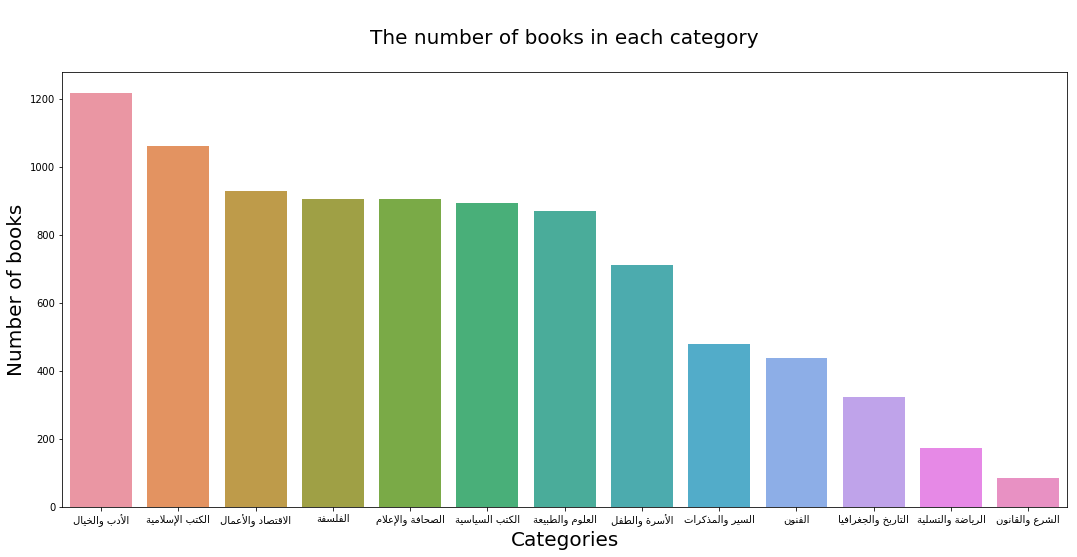

In [795]:
# Count the books in each category
indices = books_df.Category.value_counts().index
count = books_df.Category.value_counts().values
categories = []
# Reshape categories Arabic names in readable shape  
for cat in indices:
    reshaped_text = arabic_reshaper.reshape(cat)
    artext = get_display(reshaped_text)
    categories.append(artext)
plt.figure(figsize=(18,8))
sns.barplot(x = categories, y=count)
plt.title("\nThe number of books in each category\n", fontdict={'fontsize':20})
plt.xlabel('Categories',fontdict={'fontsize':20})
plt.ylabel('Number of books',fontdict={'fontsize':20})
plt.show()

**Is there any relation between the number of pages in a book and its price?**

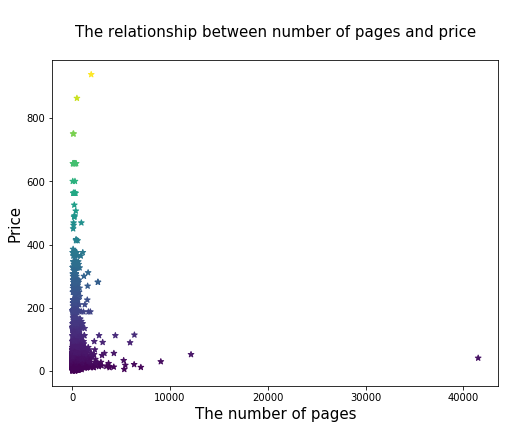

In [801]:
x = books_df[~(books_df['Pages']==0)]['Pages']
y =  books_df[~(books_df['Pages']==0)].Price
plt.figure(figsize=(8,6))
plt.scatter(x,y,c =y,  cmap='viridis', marker='*')
plt.title("\nThe relationship between number of pages and price\n", fontdict={'fontsize':15})
plt.xlabel('The number of pages',fontdict={'fontsize':15})
plt.ylabel('Price',fontdict={'fontsize':15})
plt.show()


**Check if there are any outliers in the numeric columns**

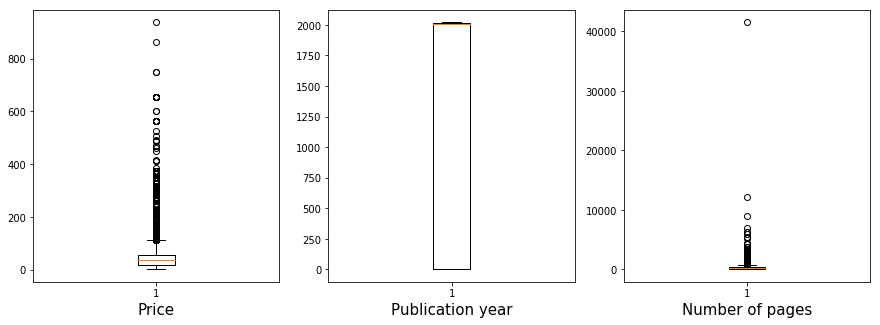

In [819]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figheight(5)
f.set_figwidth(15)
ax1.boxplot(books_df.Price)
ax1.set_xlabel("Price", fontdict={'fontsize':15})
ax2.boxplot(books_df["Publication year"])
ax2.set_xlabel("Publication year", fontdict={'fontsize':15})
ax3.boxplot(books_df.Pages)
ax3.set_xlabel("Number of pages", fontdict={'fontsize':15})
plt.show()

In [772]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(16,12))

    # Generate a mask for the upper triangle (taken from the Seaborn example gallery):
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with Seaborn.
    # Assign the matplotlib axis the function returns. This allow us to resize the labels.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.title("\nThe correlation between  dataset features\n", fontdict = {'fontsize':20})
    plt.show()

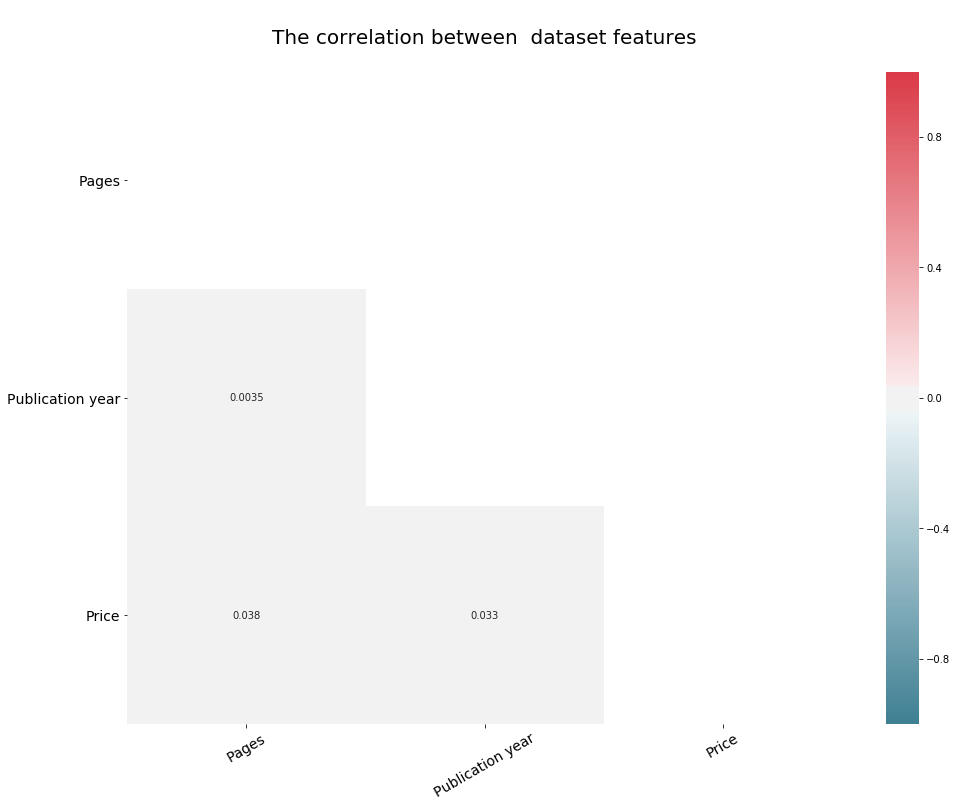

In [773]:
correlation_heat_map(books_df)